In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Part 1: Data Preparation and Exploration
# Load dataset
df = pd.read_csv('exchange_rate.csv')

# Display first few rows
print("Dataset preview:")
print(df.head())

Dataset preview:
               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849


In [4]:
# Parse date column and set as index
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%d-%m-%Y %H:%M')
df.set_index(df.columns[0], inplace=True)
df = df.asfreq('D')  # assuming daily data; adjust if needed

# Rename columns for clarity
df.columns = ['USD_AUD']

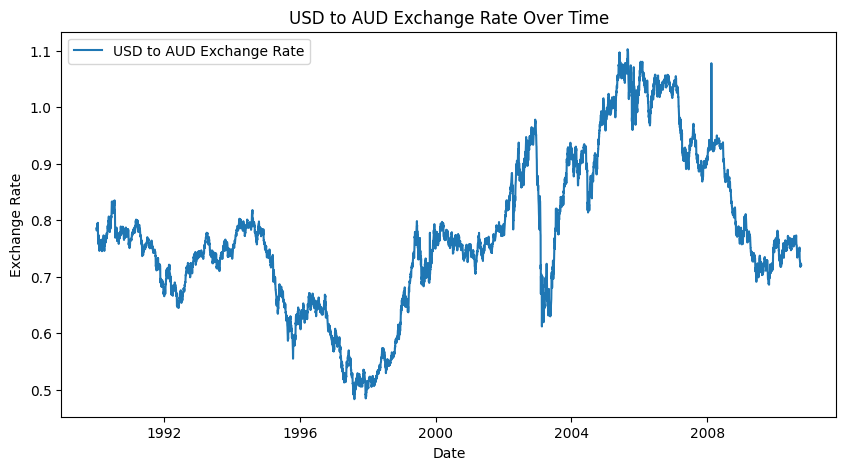


Missing values in dataset:
USD_AUD    0
dtype: int64


In [5]:
# Handle missing values (forward fill)
df['USD_AUD'] = df['USD_AUD'].fillna(method='ffill')

# Plot the time series
plt.figure(figsize=(10,5))
plt.plot(df['USD_AUD'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Check for missing values
print("\nMissing values in dataset:")
print(df.isnull().sum())


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Series is non-stationary; differencing required.


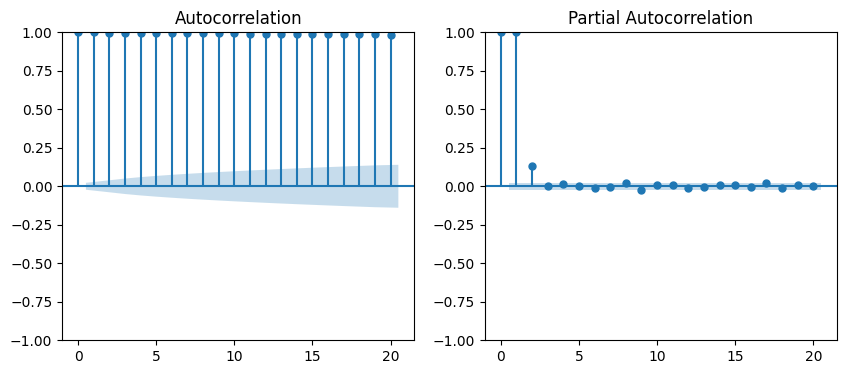

In [6]:
# Stationarity Check using ADF Test
result = adfuller(df['USD_AUD'])
print('\nADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    print("Series is non-stationary; differencing required.")
    df['USD_AUD_diff'] = df['USD_AUD'].diff().dropna()
else:
    print("Series is stationary.")

# Plot ACF and PACF to find ARIMA parameters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_acf(df['USD_AUD'].dropna(), ax=plt.gca(), lags=20)
plt.subplot(1,2,2)
plot_pacf(df['USD_AUD'].dropna(), ax=plt.gca(), lags=20)
plt.show()


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Mon, 27 Oct 2025   AIC                         -45432.092
Time:                        08:35:53   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

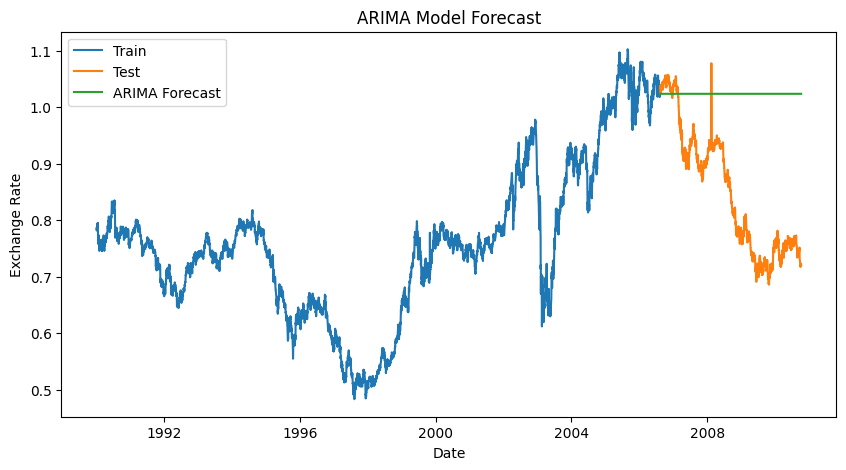

In [7]:
# Part 2: Model Building - ARIMA
# Define training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['USD_AUD'][:train_size], df['USD_AUD'][train_size:]

# Fit ARIMA model (example parameters, adjust based on plots)
model_arima = ARIMA(train, order=(1,1,1))
arima_fit = model_arima.fit()

# Summary
print(arima_fit.summary())

# Forecast
forecast_arima = arima_fit.forecast(steps=len(test))
forecast_arima = pd.Series(forecast_arima, index=test.index)

# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_arima, label='ARIMA Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

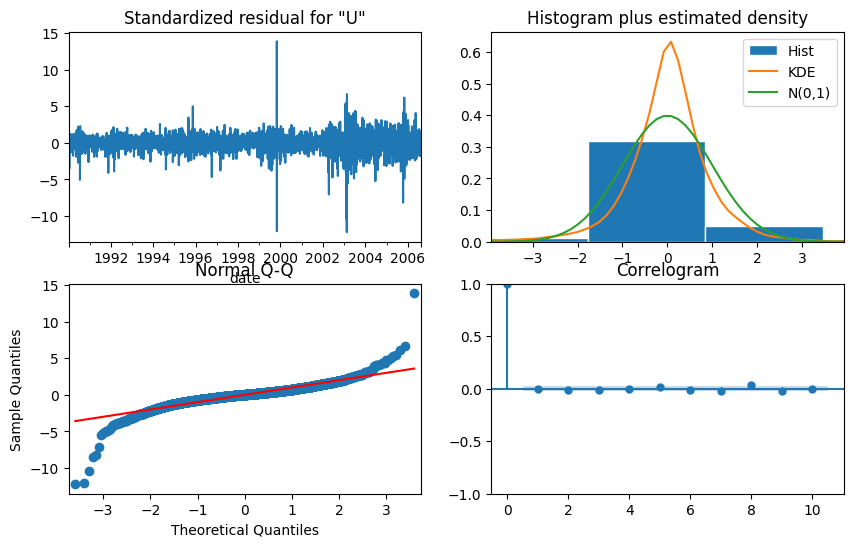

In [8]:
# Diagnostics
arima_fit.plot_diagnostics(figsize=(10,6))
plt.show()

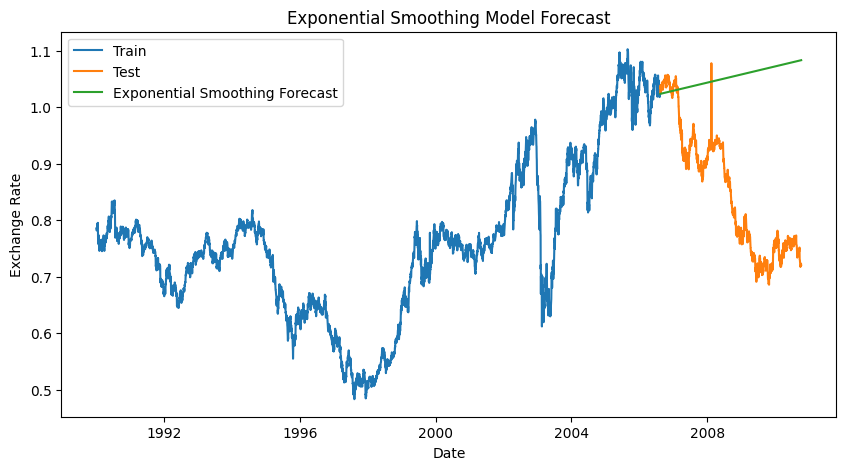

In [9]:
# Part 3: Model Building - Exponential Smoothing
# Fit Holt-Winters Exponential Smoothing model
model_es = ExponentialSmoothing(train, trend='add', seasonal=None)
fit_es = model_es.fit()

# Forecast
forecast_es = fit_es.forecast(len(test))
forecast_es = pd.Series(forecast_es, index=test.index)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_es, label='Exponential Smoothing Forecast')
plt.title('Exponential Smoothing Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()



Model Performance Comparison:
                   Model       MAE      RMSE   MAPE (%)
0                  ARIMA  0.177710  0.205437  22.797966
1  Exponential Smoothing  0.206596  0.239104  26.508664


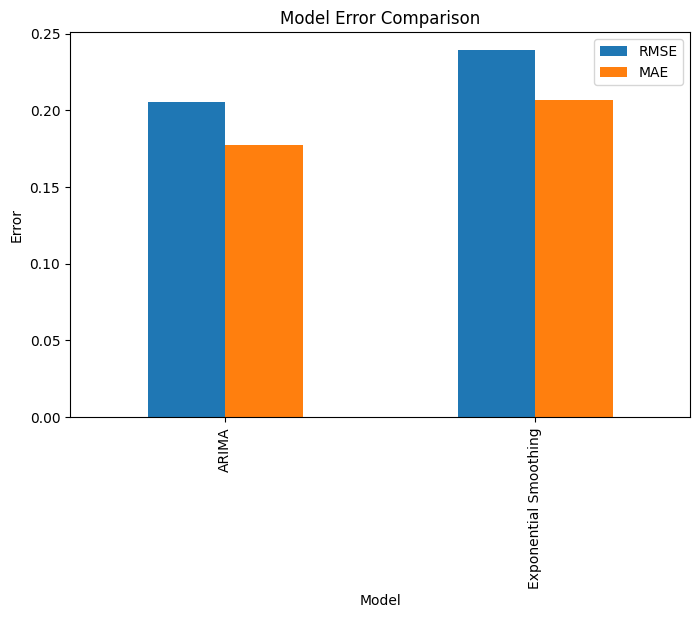

In [10]:
# Part 4: Evaluation and Comparison
# Compute error metrics
def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

mae_arima, rmse_arima, mape_arima = evaluate_model(test, forecast_arima)
mae_es, rmse_es, mape_es = evaluate_model(test, forecast_es)

# Display results
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [mae_arima, mae_es],
    'RMSE': [rmse_arima, rmse_es],
    'MAPE (%)': [mape_arima, mape_es]
})

print("\nModel Performance Comparison:")
print(comparison)

# Plot comparison
comparison.set_index('Model')[['RMSE', 'MAE']].plot(kind='bar', figsize=(8,5))
plt.title('Model Error Comparison')
plt.ylabel('Error')
plt.show()


In [11]:
# Conclusion
best_model = 'ARIMA' if rmse_arima < rmse_es else 'Exponential Smoothing'
print(f"\nConclusion: The {best_model} model performed better based on RMSE and MAE.")


Conclusion: The ARIMA model performed better based on RMSE and MAE.
